## Layer Diffuse + Style Aligned

In [15]:
from layerdiffuse.inference import load_models, dtype_from_str
from pathlib import Path
import torch 
from refiners.fluxion.utils import (
    manual_seed,
    no_grad,
    images_to_tensor,
    tensor_to_images
)
from PIL import Image
from tqdm import tqdm
from refiners.foundationals.latent_diffusion.style_aligned import StyleAlignedAdapter


In [2]:
save_path = Path("/home/chloedaems0/layerdiffuse/outputs/")
save_path.mkdir(parents=True, exist_ok=True)
checkpoint_path = Path("/home/chloedaems0/layerdiffuse/checkpoints/")
device = torch.device("cuda")
dtype = dtype_from_str("bfloat16")
sdxl, transparent_decoder = load_models(checkpoint_path, device=device, dtype=dtype)
manual_seed(seed=1234)

In [3]:
#Add Style Align
style_aligned_adapter = StyleAlignedAdapter(sdxl.unet)
style_aligned_adapter.inject()
print("ok")

ok


In [4]:
#prompt = "portrait of a futuristic stylized panda mage, holding a crystal ball in his hands,purple glow, cyberpunk, animation"
set_of_prompts = [
        "an toy train. full view, macro photo. 3d game asset, best quality, high quality, no shadows",
        "a toy airplane. full view, macro photo. 3d game asset, best quality, high quality, no shadows",
        "a toy bicycle. full view, macro photo. 3d game asset, best quality, high quality, no shadows",
    ]

100%|██████████| 30/30 [00:48<00:00,  1.63s/it]


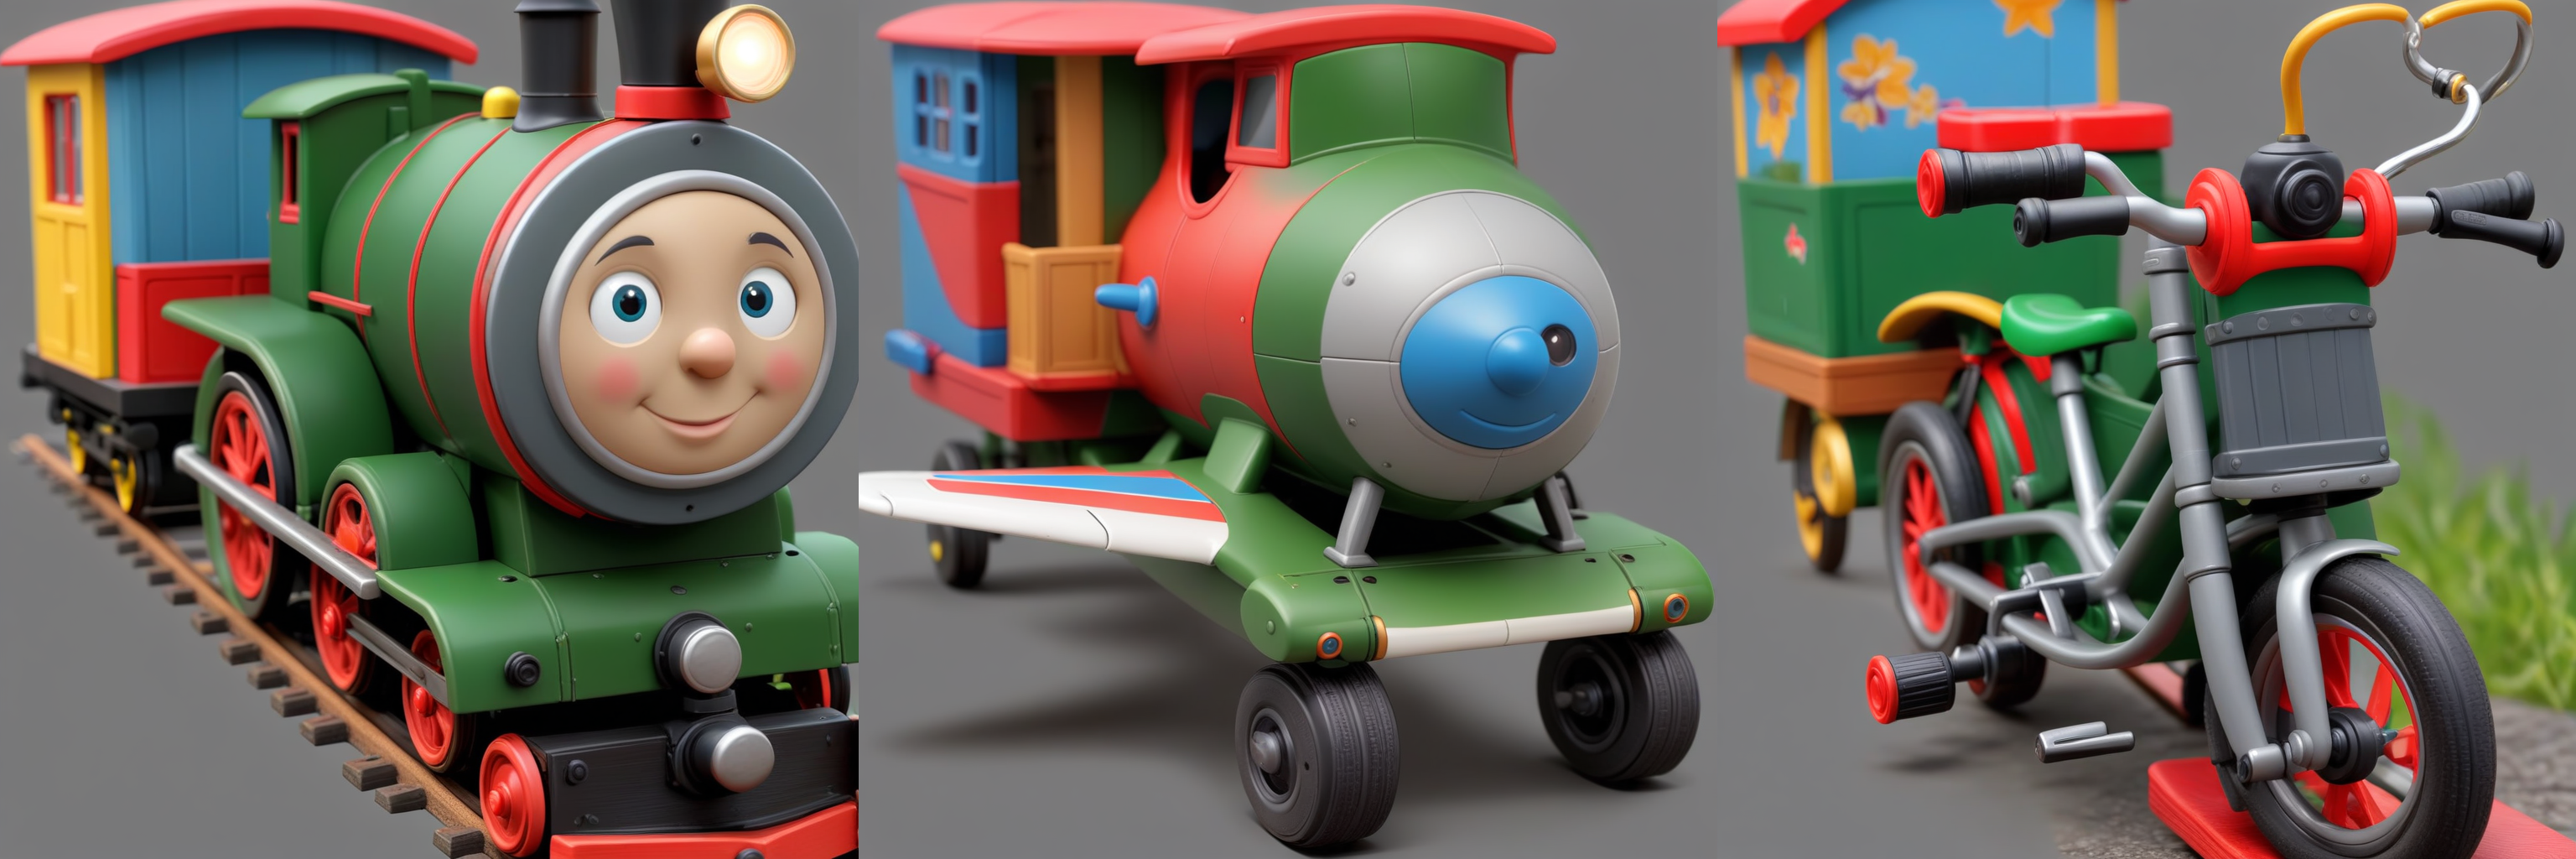

In [5]:
with no_grad():
        # clip_text_embedding, pooled_text_embedding = sdxl.compute_clip_text_embedding(
        #     text=prompt + ", best quality, high quality",
        #     negative_text="monochrome, lowres, bad anatomy, worst quality, low quality",
        # )
        clip_text_embedding, pooled_text_embedding = sdxl.compute_clip_text_embedding(
        text=set_of_prompts, negative_text=["monochrome, lowres, bad anatomy, worst quality, low quality, background"] * len(set_of_prompts)
    )
        #time_ids = sdxl.default_time_ids
        time_ids = sdxl.default_time_ids.repeat(len(set_of_prompts), 1)

        #x = sdxl.init_latents((1024, 1024)).to(device=device, dtype=dtype)
        x = torch.randn(
        (len(set_of_prompts), 4, 128, 128),
        device=sdxl.device,
        dtype=sdxl.dtype,
        )
        for step in tqdm(sdxl.steps):
            x = sdxl(
                x,
                step=step,
                clip_text_embedding=clip_text_embedding,
                pooled_text_embedding=pooled_text_embedding,
                time_ids=time_ids,
            )
        #latent = x
        #pixel = sdxl.lda.decode_latents(x)
        predicted_images = [sdxl.lda.decode_latents(latent.unsqueeze(0)) for latent in x]
        # tile all images horizontally
        merged_image = Image.new("RGB", (1024 * len(predicted_images), 1024))
        for i in range(len(predicted_images)): # type: ignore
            merged_image.paste(predicted_images[i], (i * 1024, 0))
        
merged_image

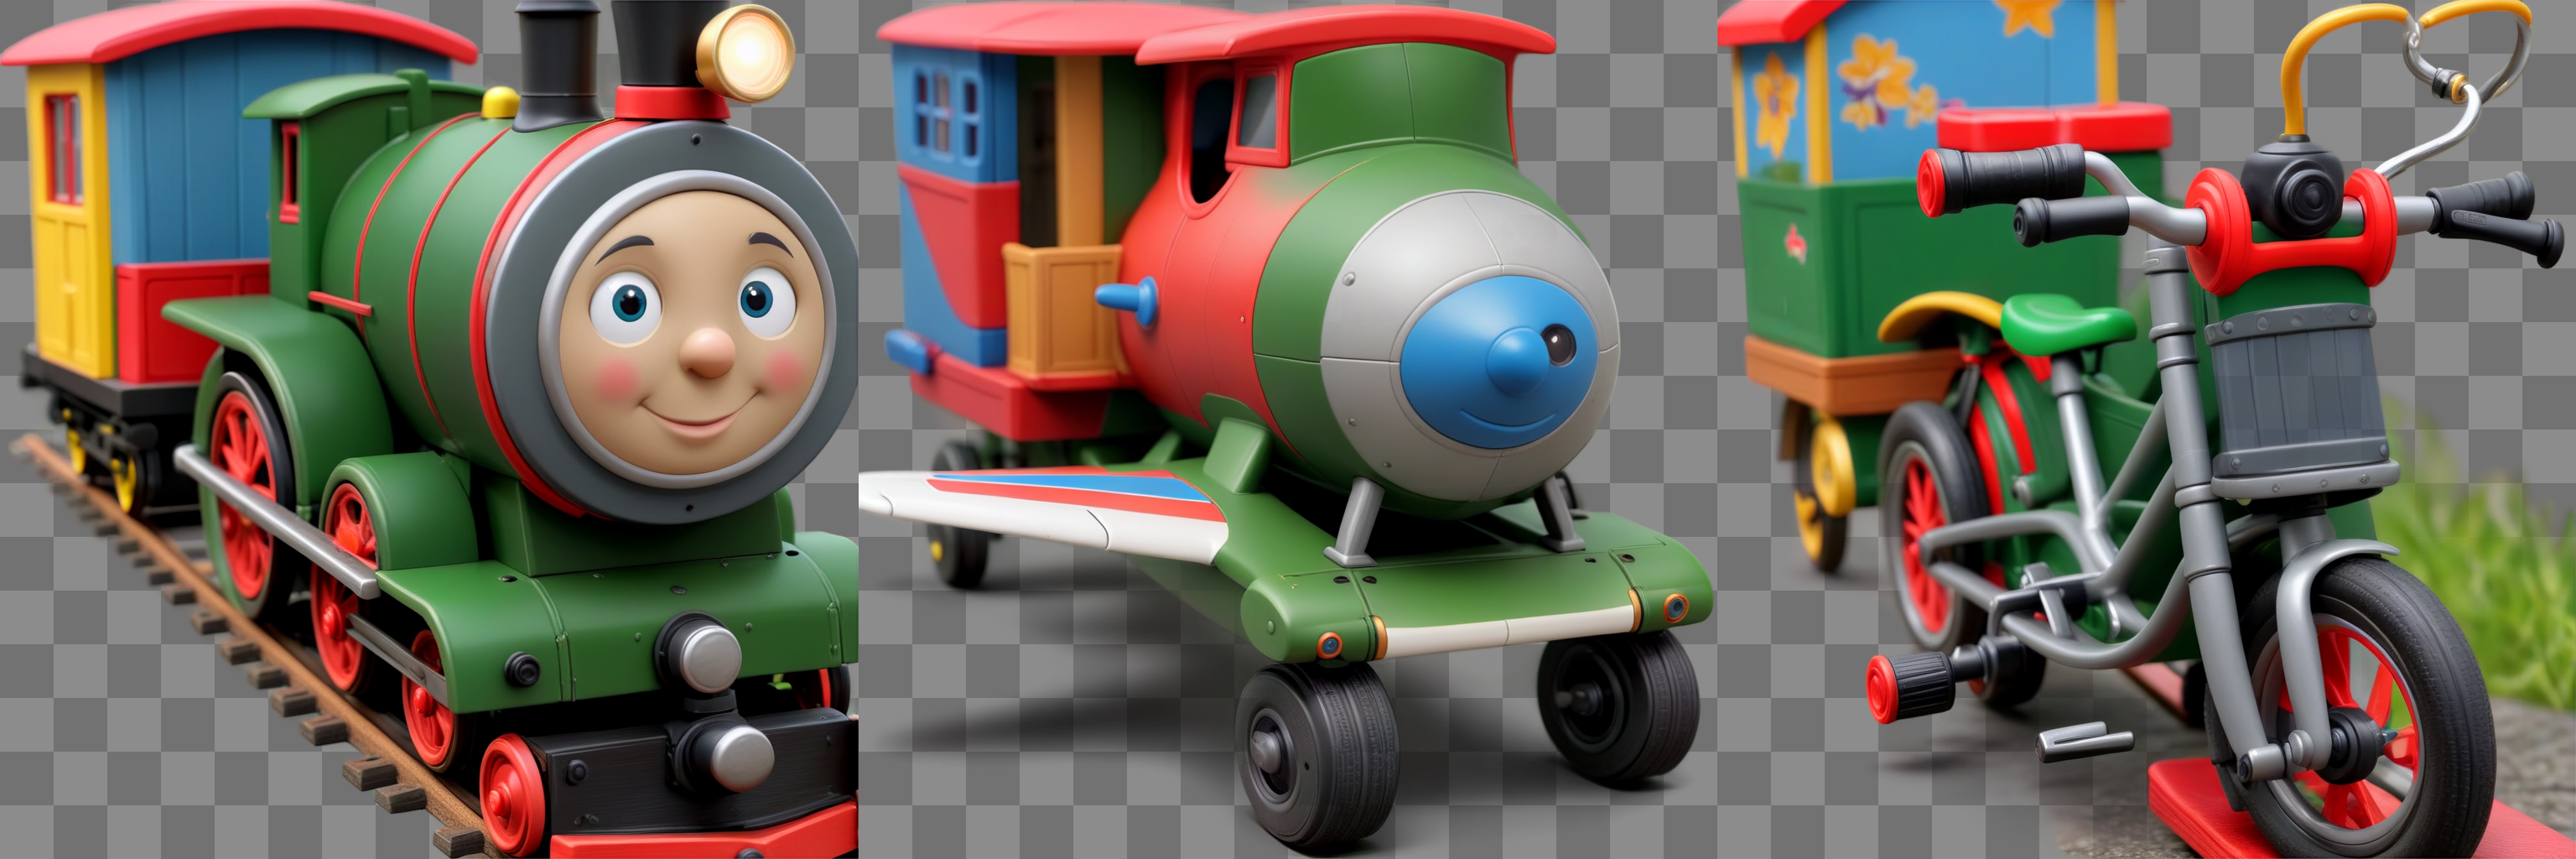

In [21]:
with no_grad():
    pixels = images_to_tensor(predicted_images, dtype=dtype, device=device)
    transparent_images, transparent_images_png = transparent_decoder.run(pixels, x)

merged_image = Image.new("RGB", (1024 * len(predicted_images), 1024))
transparent_images = tensor_to_images(transparent_images)

for i in range(len(transparent_images)): # type: ignore
    merged_image.paste(transparent_images[i], (i * 1024, 0))# type:ignore

merged_image